In [1]:
from google.colab import files
uploaded = files.upload()

Saving candidate_dataset.npz to candidate_dataset.npz


In [2]:
import numpy as np

filename = list(uploaded.keys())[0]
data = np.load(filename)

print("Keys:", data.files)
for k in data.files:
    print(k, data[k].shape)

Keys: ['x_train', 'y_train', 'x_val', 'y_val']
x_train (7007, 28, 28, 3)
y_train (7007, 1)
x_val (1003, 28, 28, 3)
y_val (1003, 1)


/tmp/ipython-input-1607254349.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(int(y[i]))


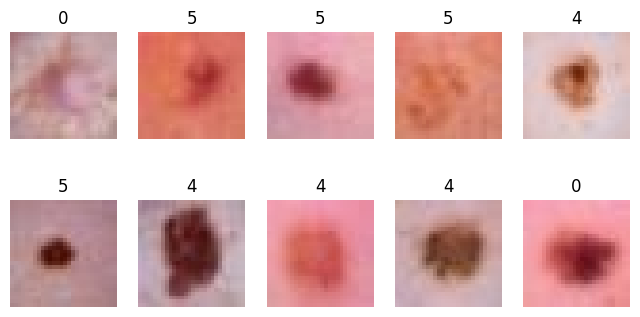

In [3]:
import matplotlib.pyplot as plt

x = data[data.files[0]]
y = data[data.files[1]]

plt.figure(figsize=(8,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x[i], cmap='gray')
    plt.title(int(y[i]))
    plt.axis('off')
plt.show()

EDA + Preprocessing

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [5]:
data = np.load(filename)

x_train = data['x_train']
y_train = data['y_train'].squeeze()   # (7007,)
x_val = data['x_val']
y_val = data['y_val'].squeeze()       # (1003,)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(7007, 28, 28, 3) (7007,)
(1003, 28, 28, 3) (1003,)


Train class distribution: Counter({np.uint8(5): 2973, np.uint8(4): 884, np.uint8(2): 845, np.uint8(1): 670, np.uint8(0): 616, np.uint8(3): 520, np.uint8(6): 499})
Val class distribution: Counter({np.uint8(5): 671, np.uint8(4): 111, np.uint8(2): 110, np.uint8(1): 52, np.uint8(0): 33, np.uint8(6): 14, np.uint8(3): 12})


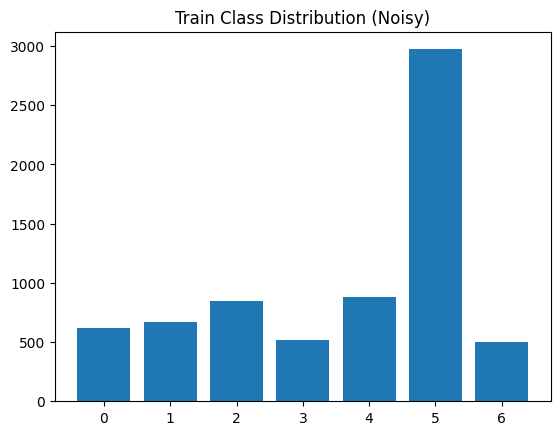

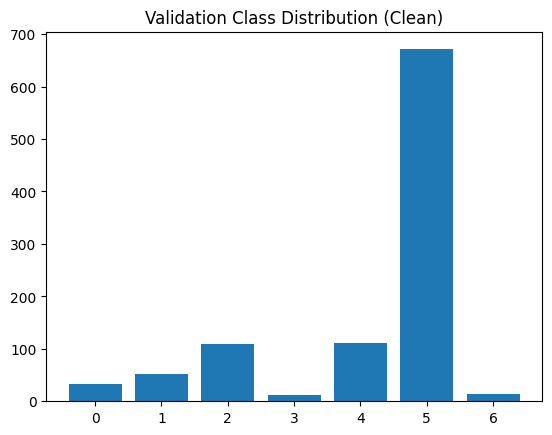

In [6]:
train_counts = Counter(y_train)
val_counts = Counter(y_val)

print("Train class distribution:", train_counts)
print("Val class distribution:", val_counts)

plt.bar(train_counts.keys(), train_counts.values())
plt.title("Train Class Distribution (Noisy)")
plt.show()

plt.bar(val_counts.keys(), val_counts.values())
plt.title("Validation Class Distribution (Clean)")
plt.show()

Train pixel range: 0 255
Val pixel range: 0 255


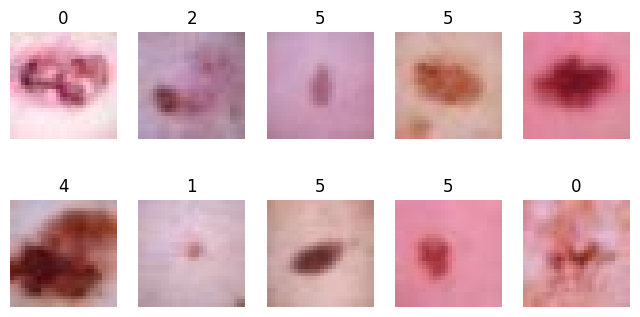

In [7]:
print("Train pixel range:", x_train.min(), x_train.max())
print("Val pixel range:", x_val.min(), x_val.max())

# Show few random images
idx = np.random.choice(len(x_train), 10, replace=False)
plt.figure(figsize=(8,4))
for i,j in enumerate(idx):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[j].astype(np.uint8))
    plt.title(int(y_train[j]))
    plt.axis('off')
plt.show()

PREPROCESSING + PYTORCH PIPELINE

In [8]:
# Normalize
x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0

# Change shape: (N, H, W, C) → (N, C, H, W)
x_train = np.transpose(x_train, (0, 3, 1, 2))
x_val = np.transpose(x_val, (0, 3, 1, 2))

print(x_train.shape, x_val.shape)

(7007, 3, 28, 28) (1003, 3, 28, 28)


In [9]:
class SkinDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [10]:
train_ds = SkinDataset(x_train, y_train)
val_ds = SkinDataset(x_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 110
Val batches: 8


CNN WORKING MODEL

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

model = SimpleCNN(num_classes=7).to(device)
print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Linear(in_features=128, out_features=7, bias=True)
)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc


def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)

            total_loss += loss.item() * X.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc


In [14]:
num_epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accs.append(tr_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10 | Train Loss: 1.6774, Train Acc: 0.4172 | Val Loss: 1.0835, Val Acc: 0.6690
Epoch 2/10 | Train Loss: 1.6440, Train Acc: 0.4331 | Val Loss: 1.0406, Val Acc: 0.6700
Epoch 3/10 | Train Loss: 1.6324, Train Acc: 0.4367 | Val Loss: 1.1181, Val Acc: 0.6849
Epoch 4/10 | Train Loss: 1.6300, Train Acc: 0.4403 | Val Loss: 1.1441, Val Acc: 0.6959
Epoch 5/10 | Train Loss: 1.6201, Train Acc: 0.4423 | Val Loss: 1.1501, Val Acc: 0.7109
Epoch 6/10 | Train Loss: 1.6167, Train Acc: 0.4457 | Val Loss: 1.3834, Val Acc: 0.5982
Epoch 7/10 | Train Loss: 1.6168, Train Acc: 0.4467 | Val Loss: 1.2565, Val Acc: 0.7129
Epoch 8/10 | Train Loss: 1.6089, Train Acc: 0.4533 | Val Loss: 1.2343, Val Acc: 0.7119
Epoch 9/10 | Train Loss: 1.6081, Train Acc: 0.4488 | Val Loss: 1.0812, Val Acc: 0.6810
Epoch 10/10 | Train Loss: 1.6064, Train Acc: 0.4510 | Val Loss: 1.0734, Val Acc: 0.6859


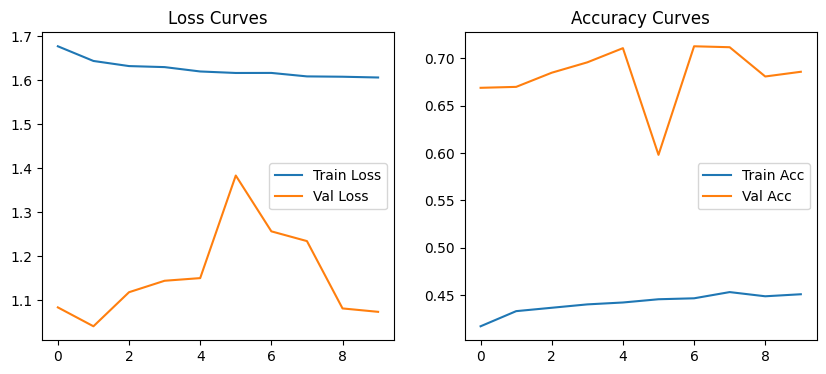

In [15]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy Curves")
plt.show()


LABEL SMOOTHING LOSS

In [16]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=7, smoothing=0.1):
        super().__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, pred, target):
        log_probs = torch.log_softmax(pred, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))


CONFIDENT LEARNING–STYLE SAMPLE FILTERING

In [17]:
def get_losses_per_sample(model, loader, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = nn.CrossEntropyLoss(reduction='none')(outputs, y)
            losses.extend(loss.cpu().numpy())
    return np.array(losses)


In [18]:
def compute_sample_weights(losses, keep_ratio=0.7):
    threshold = np.quantile(losses, keep_ratio)
    weights = (losses <= threshold).astype(float)
    return weights

NOISE-ROBUST TRAINING LOOP

In [19]:
class WeightedSkinDataset(Dataset):
    def __init__(self, X, y, weights):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.w = torch.tensor(weights, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.w[idx]


In [20]:
def train_weighted_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for X, y, w in loader:
        X, y, w = X.to(device), y.to(device), w.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss = (loss * w).mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc


In [21]:
# 1️⃣ Reinitialize model
model_nr = SimpleCNN(num_classes=7).to(device)
criterion_ls = LabelSmoothingLoss(classes=7, smoothing=0.1)
optimizer_nr = optim.Adam(model_nr.parameters(), lr=1e-3)

# 2️⃣ Warm-up training
print("Warm-up training...")
for epoch in range(3):
    tr_loss, tr_acc = train_one_epoch(model_nr, train_loader, optimizer_nr, nn.CrossEntropyLoss())
    val_loss, val_acc = eval_one_epoch(model_nr, val_loader, nn.CrossEntropyLoss())
    print(f"Warmup Epoch {epoch+1} | Val Acc: {val_acc:.4f}")

# 3️⃣ Estimate noisy samples
print("Estimating noisy samples...")
losses = get_losses_per_sample(model_nr, train_loader, nn.CrossEntropyLoss())
weights = compute_sample_weights(losses, keep_ratio=0.7)

print("Trusted samples:", weights.sum(), "/", len(weights))

# 4️⃣ Weighted dataset
weighted_train_ds = WeightedSkinDataset(x_train, y_train, weights)
weighted_loader = DataLoader(weighted_train_ds, batch_size=64, shuffle=True)

# 5️⃣ Noise-robust training
num_epochs = 10
nr_train_losses, nr_val_losses = [], []
nr_train_accs, nr_val_accs = [], []

for epoch in range(num_epochs):
    tr_loss, tr_acc = train_weighted_epoch(model_nr, weighted_loader, optimizer_nr, criterion_ls)
    val_loss, val_acc = eval_one_epoch(model_nr, val_loader, nn.CrossEntropyLoss())

    nr_train_losses.append(tr_loss)
    nr_val_losses.append(val_loss)
    nr_train_accs.append(tr_acc)
    nr_val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | "
          f"Val Acc: {val_acc:.4f}")


Warm-up training...
Warmup Epoch 1 | Val Acc: 0.6780
Warmup Epoch 2 | Val Acc: 0.6969
Warmup Epoch 3 | Val Acc: 0.6800
Estimating noisy samples...
Trusted samples: 4905.0 / 7007
Epoch 1/10 | Train Loss: 1.1823, Train Acc: 0.4443 | Val Acc: 0.7159
Epoch 2/10 | Train Loss: 1.1811, Train Acc: 0.4421 | Val Acc: 0.7198
Epoch 3/10 | Train Loss: 1.1764, Train Acc: 0.4463 | Val Acc: 0.7258
Epoch 4/10 | Train Loss: 1.1767, Train Acc: 0.4481 | Val Acc: 0.7159
Epoch 5/10 | Train Loss: 1.1759, Train Acc: 0.4484 | Val Acc: 0.6919
Epoch 6/10 | Train Loss: 1.1740, Train Acc: 0.4503 | Val Acc: 0.6859
Epoch 7/10 | Train Loss: 1.1714, Train Acc: 0.4530 | Val Acc: 0.7039
Epoch 8/10 | Train Loss: 1.1703, Train Acc: 0.4501 | Val Acc: 0.6092
Epoch 9/10 | Train Loss: 1.1684, Train Acc: 0.4514 | Val Acc: 0.7119
Epoch 10/10 | Train Loss: 1.1681, Train Acc: 0.4547 | Val Acc: 0.6959


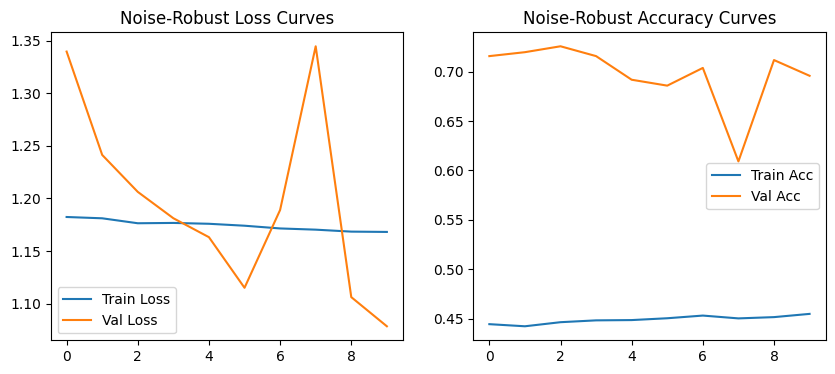

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(nr_train_losses, label="Train Loss")
plt.plot(nr_val_losses, label="Val Loss")
plt.legend()
plt.title("Noise-Robust Loss Curves")

plt.subplot(1,2,2)
plt.plot(nr_train_accs, label="Train Acc")
plt.plot(nr_val_accs, label="Val Acc")
plt.legend()
plt.title("Noise-Robust Accuracy Curves")
plt.show()


In [23]:
torch.save(model_nr.state_dict(), "skin_model_noise_robust.pth")
print("Model saved.")

Model saved.


In [24]:
loaded_model = SimpleCNN(num_classes=7).to(device)
loaded_model.load_state_dict(torch.load("skin_model_noise_robust.pth", map_location=device))
loaded_model.eval()
print("Model loaded successfully.")

Model loaded successfully.


LIVE INFERENCE FUNCTION

In [25]:
def run_inference_on_npz(npz_path, model_path="skin_model_noise_robust.pth"):
    import numpy as np
    import torch
    from sklearn.metrics import accuracy_score

    data = np.load(npz_path)
    x = data['x_val']
    y = data['y_val'].squeeze()

    # Preprocess
    x = x.astype("float32") / 255.0
    x = np.transpose(x, (0, 3, 1, 2))
    x = torch.tensor(x, dtype=torch.float32)

    # Load model
    model = SimpleCNN(num_classes=7)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()

    with torch.no_grad():
        outputs = model(x)
        preds = outputs.argmax(dim=1).numpy()

    acc = accuracy_score(y, preds)
    print("Accuracy on provided dataset:", acc)
    return acc


In [26]:
def predict_single_image(img_array, model):
    """
    img_array: (28,28,3) numpy array
    """
    img = img_array.astype("float32") / 255.0
    img = np.transpose(img, (2,0,1))
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)

    with torch.no_grad():
        logits = model(img)
        pred = logits.argmax(dim=1).item()
    return pred


In [27]:
from google.colab import files
files.download("skin_model_noise_robust.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>